# Stereo Matching with TensorFlow and Pytorch Model

## Package Install

In [1]:
!pip install -r requirements.txt
import tensorflow as tf
import torch
import torch.nn as nn
import time
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

from tf_model import Model
from torch_model import TorchModel

device = 'cuda:0'
max_disp = 192

## Dataset Preparing

In [2]:
root = './data/'
left_root = root + 'left/'
right_root = root + 'right/'

imgs = os.listdir(left_root)
imgs = [im for im in imgs if im.find('_10.png') > -1]
imgs.sort()
print(f'{len(imgs)} images found!')

left_imgs = [os.path.join(left_root, im) for im in imgs]
right_imgs = [os.path.join(right_root, im) for im in imgs]

target_size = (256, 512)

def mean_std(inputs):
    inputs = np.float32(inputs) / 255.
    inputs[:, :, 0] -= 0.485
    inputs[:, :, 0] /= 0.229
    inputs[:, :, 1] -= 0.456
    inputs[:, :, 1] /= 0.224
    inputs[:, :, 2] -= 0.406
    inputs[:, :, 2] /= 0.225
    
    return inputs

def load_batch(left, right, patch_size):
    batch_left = []
    batch_right = []
    for x, y in zip(left, right):
        crop_x = (368 - patch_size[0]) // 2
        crop_y = (1224 - patch_size[1]) // 2

        x = cv2.imread(x)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = x[crop_x: crop_x + patch_size[0], crop_y: crop_y + patch_size[1], :]
        batch_left.append(x)

        y = cv2.imread(y)
        y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
        y = y[crop_x: crop_x + patch_size[0], crop_y: crop_y + patch_size[1], :]
        batch_right.append(y)
        
    return batch_left, batch_right

left_imgs, right_imgs = load_batch(left_imgs, right_imgs, patch_size=target_size)

print('Data loaded!')

2 images found!
Data loaded!


## PyTorch Model Running


************************    Example 0    ************************

        Left Image                Reft Image                Depth


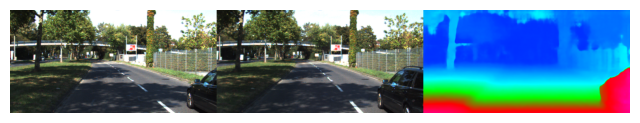


************************    Example 1    ************************

        Left Image                Reft Image                Depth


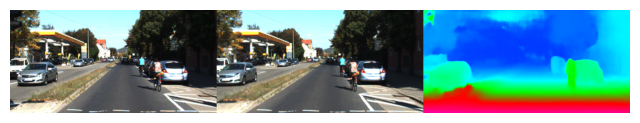

In [3]:
torch_net = TorchModel(max_disp=max_disp)
checkpoint = torch.load('./ckpt/torch_final.ckpt')
# checkpoint = torch.load('./ckpt/net-300.ckpt')
torch_net.load_state_dict(checkpoint['state_dict'])
torch_net = torch_net.to(device)

with torch.no_grad():
    for batch_idx, (imgL, imgR) in enumerate(zip(left_imgs, right_imgs)):
        imgL_t = torch.from_numpy(mean_std(imgL)).to(device).unsqueeze(dim=0).permute(0, 3, 1, 2)
        imgR_t = torch.from_numpy(mean_std(imgR)).to(device).unsqueeze(dim=0).permute(0, 3, 1, 2)
        disp = torch_net.batch_predict(imgL_t, imgR_t)
        disp = disp[0, 0].cpu().numpy()
        
        item = (disp * 255 / disp.max()).astype(np.uint8)
        pred_rainbow = cv2.applyColorMap(item, cv2.COLORMAP_RAINBOW)[..., :3]
        all_img = np.concatenate([imgL, imgR, pred_rainbow], axis=1)
        all_img = (all_img / 255.0).clip(0, 1)
        
        n = 8
        print('\n' + '*'*n*3 + '    Example {}    '.format(batch_idx) + '*'*n*3 + '\n')
        print(' '*n + 'Left Image' + ' '*n + ' '*n + 'Reft Image' + ' '*n + ' '*n + 'Depth')
        plt.figure(figsize=(8, 24), dpi=100)
        plt.imshow(all_img)
        plt.axis('off')
        plt.show()
        plt.close()


## TensorFlow Model Running

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.AveragePooling2D instead.
Instructions for updating:
Use `tf.keras.layers.Conv3D` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Restoring parameters from ./ckpt/final.ckpt

************************    Example 0    ************************

        Left Image                Reft Image                Depth


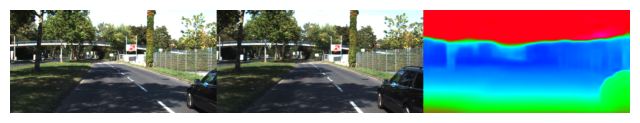


************************    Example 1    ************************

        Left Image                Reft Image                Depth


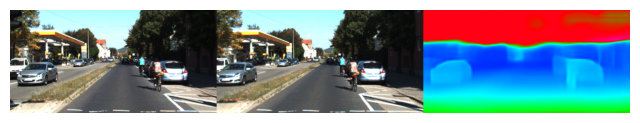

In [4]:
height, width = target_size

with tf.compat.v1.Session() as sess:
    net = Model(sess, height=height, weight=width, batch_size=1, 
                max_disp=max_disp, lr=0.001, cnn_3d_type='resnet_3d')
    saver = tf.compat.v1.train.Saver()
    saver.restore(sess, './ckpt/final.ckpt')
    
    for batch_idx, (imgL, imgR) in enumerate(zip(left_imgs, right_imgs)):
        img_L = mean_std(imgL)
        img_L = np.expand_dims(img_L, axis=0)
        img_R = mean_std(imgR)
        img_R = np.expand_dims(img_R, axis=0)
        
        pred = net.predict(img_L, img_R)
        disp = np.squeeze(pred, axis=0)
        
        item = (disp * 255 / disp.max()).astype(np.uint8)
        pred_rainbow = cv2.applyColorMap(item, cv2.COLORMAP_RAINBOW)[..., :3]
        all_img = np.concatenate([imgL, imgR, pred_rainbow], axis=1)
        all_img = (all_img / 255.0).clip(0, 1)
        
        n = 8
        print('\n' + '*'*n*3 + '    Example {}    '.format(batch_idx) + '*'*n*3 + '\n')
        print(' '*n + 'Left Image' + ' '*n + ' '*n + 'Reft Image' + ' '*n + ' '*n + 'Depth')
        plt.figure(figsize=(8, 24), dpi=100)
        plt.imshow(all_img)
        plt.axis('off')
        plt.show()
        plt.close()
        